In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, TensorDataset

In [2]:
imgs = torch.load("linear_imgs.pt")

In [3]:
imgs = imgs.squeeze(1)

In [4]:
imgs.shape

torch.Size([10000, 76, 77])

In [5]:
imgs[0].max()

tensor(1.)

In [6]:
# plt.imshow(sample_imgs[3])

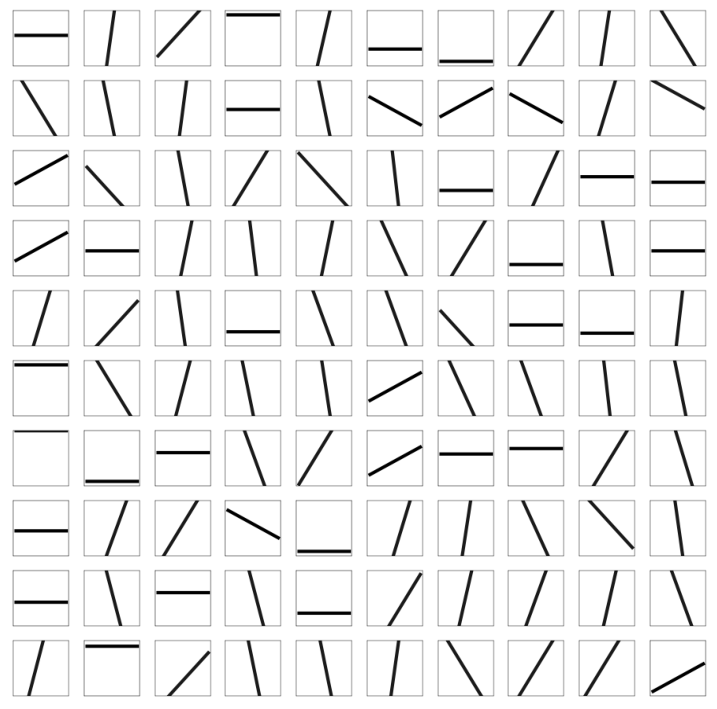

In [7]:
# num_samples = 25
sample_imgs = [i for i in imgs]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.1)

for ax, im in zip(grid, sample_imgs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [9]:
dataset = TensorDataset(imgs)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(76 * 77, 256),
            nn.ReLU(),
            nn.Linear(256, 8),
            nn.ReLU(),
            nn.Linear(8, 256),
            nn.ReLU(),
            nn.Linear(256, 76 * 77),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 76*77)
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
model = NeuralNetwork().to(device)

In [12]:
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5852, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=5852, bias=True)
    (7): Sigmoid()
  )
)


In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train(data, model, loss_fn, optimizer, id):
    size = len(data)
    model.train()
    loss_total = 0

    for x in dataloader:
        x = x[0].to(device)
        
        pred = model(x)
        loss = loss_fn(pred, x.view(-1, 76*77))
        loss_total += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (id % 10 == 0):
        print(loss_total)
    

In [15]:
train(imgs, model, loss_fn, optimizer, 1)

In [16]:
for i in range(1000):
    train(imgs, model, loss_fn, optimizer, i)

2.4182422077283263
2.023342428728938
1.818902488797903
1.6178184729069471
1.4113632184453309
1.3151437109336257
1.187510113697499
1.104212877806276
1.1139104599133134
0.9861822365783155
0.9979458600282669
0.8881436055526137
0.8299646938685328
0.9316033790819347
0.7726942978333682
0.7499466540757567
0.7857910750899464
0.7353886463679373
0.7625210229307413
0.6919068812858313
0.7373431024607271
0.6904536981601268
0.6353226657956839
0.6674555842764676
0.6199730532243848
0.6187914067413658
0.6018887755926698
0.7767173058819026
0.6473689062986523
0.5712222085567191
0.5755053337197751
0.6933167479000986
0.5592290236381814
0.5464664173778147
0.5204986142925918
0.6304920997936279
0.576777251670137
0.516215144074522
0.5222523307893425
0.5850868921261281
0.49635537434369326
0.5344821165781468
0.4981376491487026
0.48483109357766807
0.5015849260380492
0.7245655595324934
0.4789457090664655
0.5138021546881646
0.5003807718167081
0.4812510813353583
0.48612071794923395
0.5752566567389295
0.4596488731913

In [17]:
to_print = []

for i in range(25):
    pred = model(imgs[i].to(device))
    pred = pred.view(76,77)
    to_print += [imgs[i], pred.to("cpu").detach().numpy()]

In [18]:
# to_print

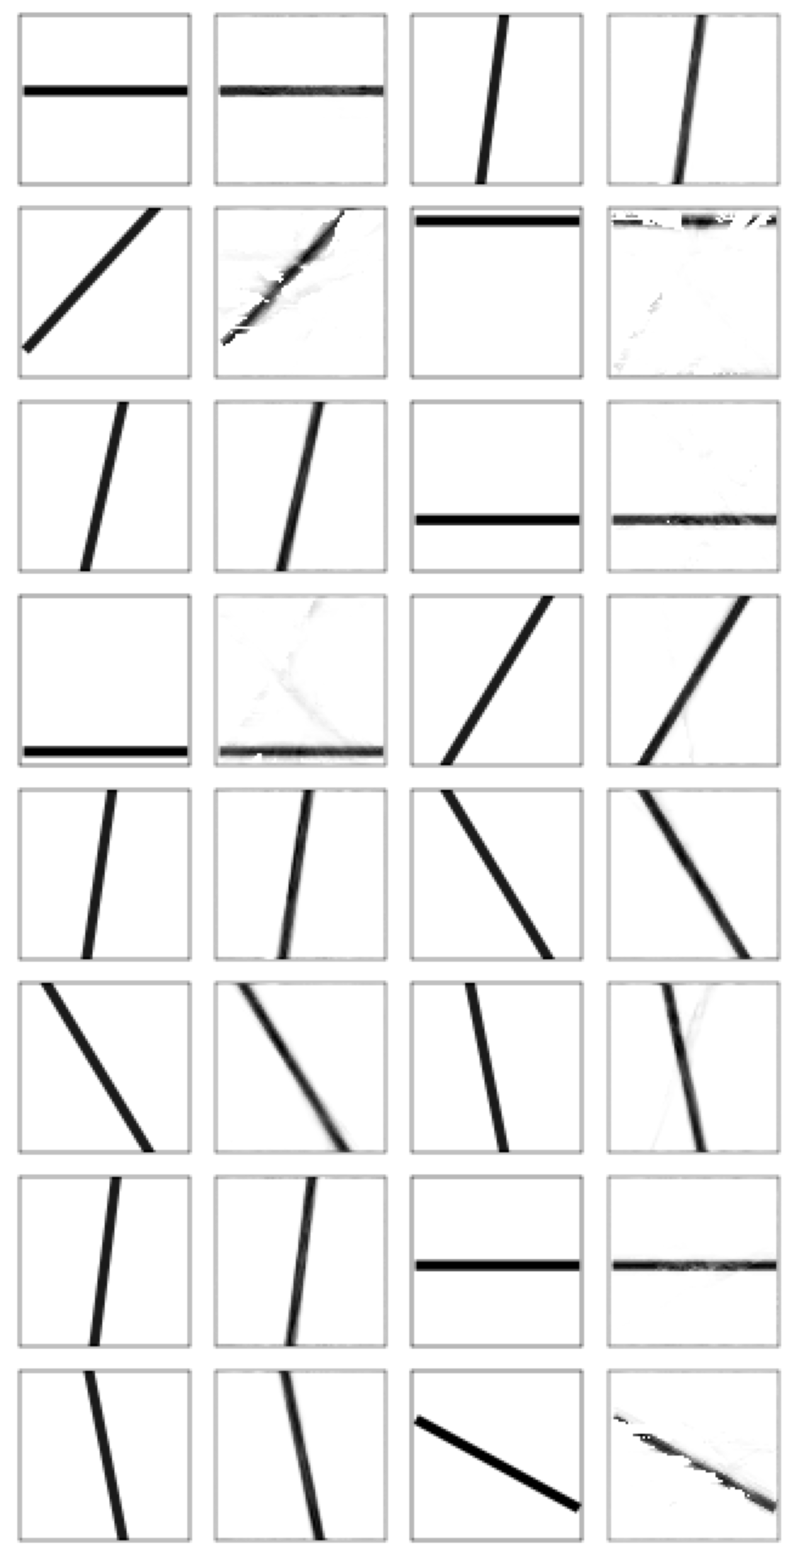

In [19]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(8,4), axes_pad=0.1)

for ax, im in zip(grid, to_print):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [20]:
model.linear_relu_stack[4]

Linear(in_features=8, out_features=256, bias=True)

In [21]:
model.linear_relu_stack[6]

Linear(in_features=256, out_features=5852, bias=True)

In [22]:
class NewNeuralNetwork(nn.Module):
    def __init__(self):
        super(NewNeuralNetwork, self).__init__()
        self.new_linear_relu_stack = nn.Sequential(
            nn.Linear(8, 256),  # This output size matches the input of the reused layer
            nn.ReLU(),
            # The next layers will be replaced with the old model's layers
            nn.Linear(256, 5852),  # Placeholder, will be replaced
            nn.Sigmoid()          # Placeholder, will be replaced
        )

    def forward(self, x):
        return self.new_linear_relu_stack(x)

In [23]:
new_model = NewNeuralNetwork()

In [24]:
new_model.new_linear_relu_stack[0].weight.data =  model.linear_relu_stack[4].weight.data

In [25]:
new_model.new_linear_relu_stack[2].weight.data = model.linear_relu_stack[6].weight.data

In [26]:
new_model.new_linear_relu_stack[2].weight.data

tensor([[ 0.0755,  0.0441, -0.0148,  ...,  0.0685,  0.1152,  0.1088],
        [ 0.0891,  0.0715,  0.0493,  ...,  0.0805,  0.0704,  0.1070],
        [ 0.1790,  0.0634,  0.0557,  ...,  0.0415,  0.0359,  0.0936],
        ...,
        [ 0.0862,  0.1476,  0.0132,  ...,  0.0475,  0.0905,  0.0677],
        [ 0.0272,  0.0431, -0.0139,  ...,  0.0750,  0.0214,  0.0407],
        [ 0.1491,  0.1106,  0.0694,  ...,  0.0407,  0.0437, -0.0034]],
       device='mps:0')

In [27]:
new_model.to(device)

NewNeuralNetwork(
  (new_linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=5852, bias=True)
    (3): Sigmoid()
  )
)

In [197]:
sample1 = new_model(torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device))

In [198]:
sample1 = sample1.view(76,77)

In [199]:
sample1 = sample1.to("cpu").detach().numpy()

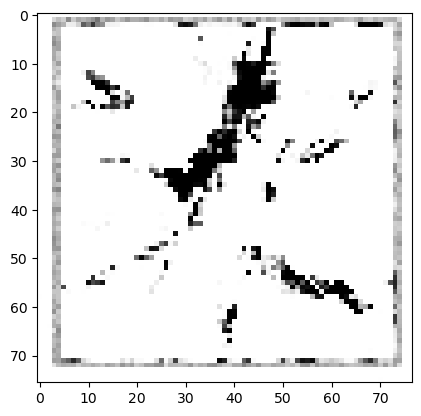

In [200]:
plt.imshow(sample1, cmap='gray')

In [201]:
inputs = [
    torch.tensor([10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
    torch.tensor([0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
    torch.tensor([0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
    torch.tensor([0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0]),
    torch.tensor([0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0]),
    torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0]),
    torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0]),
    torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0]),
]

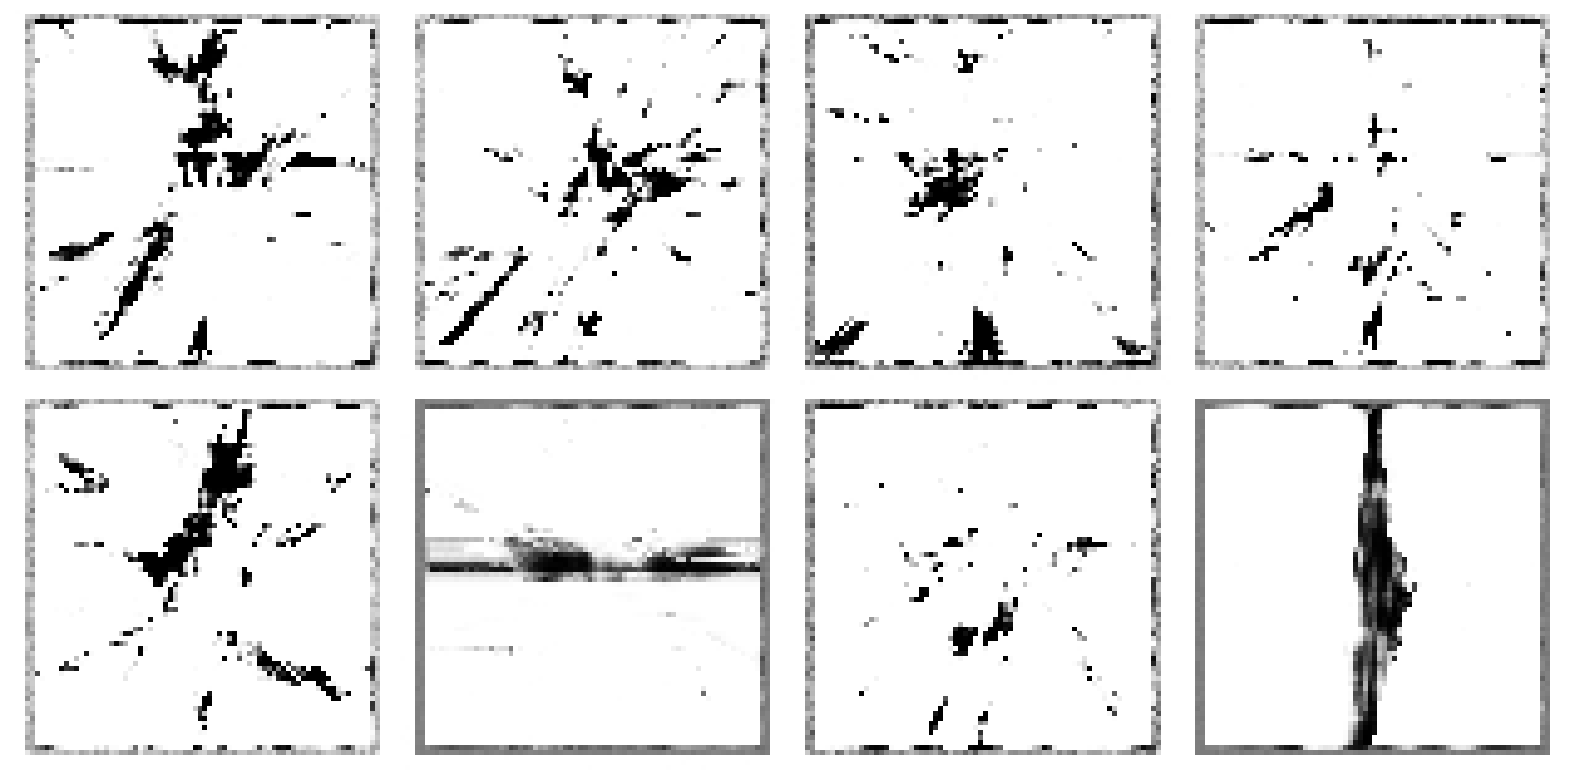

In [203]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.1)

for ax, im in zip(grid, inputs):
    pred = new_model(im.to(device))
    pred = pred.view(76,77)
    ax.imshow(pred.to("cpu").detach().numpy(), cmap='gray')
    ax.axis('off')
plt.show()